<a href="https://colab.research.google.com/github/Exanom/Shap_ConceptDirft_examples/blob/main/Abrupt_CD_Method1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Problem
W przypadku wystąpienia concept driftu przez nas klasyfikowanego jako "Abrupt", metoda wyciągania średnich z wartości absolutnych shap nie jest wystarczająca, aby go wykryć. Dzieje się tak, ponieważ ta metoda patrzy jedynie na ogólną informatywność cech, które same w sobie nie oferują wystarczająco informacji, aby wykryć "zamianę" klas. Wbudowane grafy shap ilustrują, że do wykrycia tego typu zmian dla tego typu danych wymagane są także dane o wartości cech danej próbki w relacji do ich informatywności. Jak wyżej przedstawiono, nie można patrzeć na uśrednione wartości. Pamiętajmy także że w przypadku bardziej skomplikowanych danych, relacja między wartościami cech i ich wartościami nie będzie liniowa, nie możemy zatem w jedynie patrzeć na wartości shap dla skrajnych próbek.

# Moja propozycja:
## Wartość reprezentatywna
Wyliczona dla każdej kombinacji cech i klas(w naszym przypadku: X_class0, X_class1, Y_class0, Y_class1) z nadzieją że w dalszym toku pracy możliwym będzie jeszcze większe zredukowanie wymiarowości z zachowaniem relewantnej informacji. Idea polega na znalezieniu próbki(lub wielu próbek), dla których informatywność dla danej cechy i klasy będzie najwyższa(na wykresie beeswarm danym przez shap, patrzymy na skrajnie prawą część). Następnie dla najbardziej informatywnych próbek odczytamy wartość cechy, dając nam "wartość reprezentatywną". Wizualizacja(kolory reprezentują wartości cechy dla danej próbki):
Przed CD:

![](https://drive.google.com/uc?id=19Oc-vES7W9FDlrovwTzIALddK0ClMXGf)

Po CD:

![](https://drive.google.com/uc?id=1P2T7Cwv_iQ5ds7VAxjgS2a3RablXvqDf)

W tym przypadku skrajnie wysokie i niskie wartości cech determinują o informatywności, ale pamiętajmy że dla bardziej skomplikowanych datasetów wartość najbardziej informatywna dla cechy może istnieć w jakimś przedziale pomiędzy skrajnymi wartościami. Ta metoda wychwyci też takie przypadki.

## Przykładowy algorytm
### Podejście sortowania
- Posortuj wartości shap malejącą
- Wyciągnij n pierwszych próbek
- Dla każdej cechy uśrednij jej wartości w n próbkach
- Zapisz wyniki jako wartości reprezentatywne dla całego chunka(ilość wartości cechy x klasy, w naszym przypadku 2 x 2 = 4)

### Podejście średniej ważonej
- Znormalizuj wartości shap do przedziału <0,1>, Wartości te będą działać jako "waga" dla próbki
- Dla każdej próbki, cechy i klasy, pomnóż wartości cechy razy wagę dla każdej klasy.
- Wyciągnij średnią z obliczonych wartości. Wynikiem będzie średnia ważonej dla danej cechy i klasy
- Zapisz wyniki jako wartości reprezentatywne dla całego chunka(ilość wartości cechy x klasy, w naszym przypadku 2 x 2 = 4)

Dla przykładu, po wykorzystaniu obu algorytmów zakładam że przez wystąpieniem CD(Bazując się na wcześniej pokazanych wykresach) wartość X_class1 będzie wysoka, a Y_class1 będzie niska. Po wystąpieniu CD te wartości się zamienią. Pozwoli to na wykrycie CD.

In [ ]:
!pip install shap

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import shap
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
from DataStreamGenerator_modified import DataStreamGenerator

In [ ]:
C = DataStreamGenerator(class_count=2, attribute_count=2, sample_count=10000, noise=False, redunce_variable=False)

In [ ]:
X, Y = C.Linear_Abrupt('test',False,True)
model = RandomForestClassifier()

/content/DataStreamGenerator.py:201: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(X, Y, s=area0, c="hotpink", edgecolors="g", label="class0", cmap='viridis', alpha=0.7)
/content/DataStreamGenerator.py:202: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(X, Y, s=area1, c="#88c999", edgecolors="blue", label="class1", cmap='viridis', alpha=0.7)


<Figure size 640x480 with 0 Axes>

In [ ]:
shap.initjs()

In [ ]:
shaps = []
for i in range(10):
  start = (i*1000)
  end = 1000+start
  x = X[start:end]
  y = Y[start:end]
  X_train, X_test, y_train, y_test = train_test_split(x,y,test_size=0.3,
                                                	stratify =y,
                                                	random_state = 13)
  model.fit(X_train,y_train)
  explainer = shap.TreeExplainer(model)
  sha = explainer(x)
  shaps.append(sha)
  #shap.plots.beeswarm(sha[:, :, 0])
  #shap.plots.beeswarm(sha[:, :, 0], color="shap_red")

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example usi

In [ ]:
N = 100

In [ ]:
rep_val = []

In [ ]:
tmp1 = shaps[0].values
tmp2 = shaps[0].data
for s in shaps:
  res = s[0].values
  for i in range(len(s[0])):
    for j in range(len(s[0][0])):
      sorted_shaps = sorted(s, reverse=True, key= lambda x: x.values[i][j])
      k = 0
      avg = []
      for obj in sorted_shaps:
        avg.append(obj.data[i])
        k+=1
        if(k>=N):
          break
      avg = np.array(avg)
      avg = np.mean(avg)
      res[i][j] = avg
  rep_val.append(res)

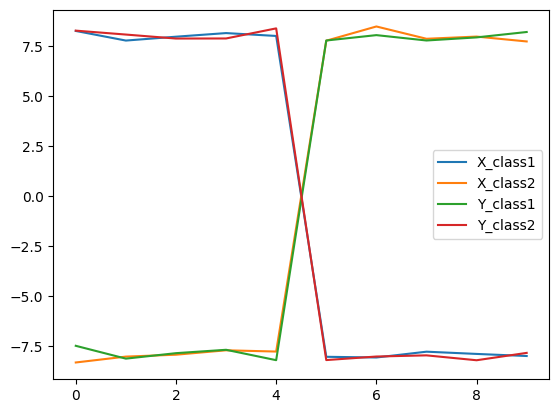

In [ ]:
rep_val = np.array(rep_val)
names = [
    ['X_class1','X_class2'],
     ['Y_class1','Y_class2']
]
for i in range(len(rep_val[0])):
  for j in range(len(rep_val[0][0])):
    plt.plot(rep_val[:,i,j], label=names[i][j])
plt.legend()
plt.show()

#Rotacyjny CD
#Sortowanie -> Średnia z top N

[[ 8.23865903 -8.30593545]
 [-7.47409161  8.25413792]]


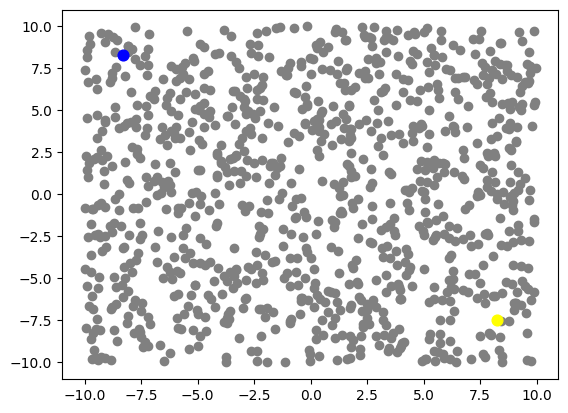

[[ 7.75872399 -8.01283023]
 [-8.11420516  8.05854726]]


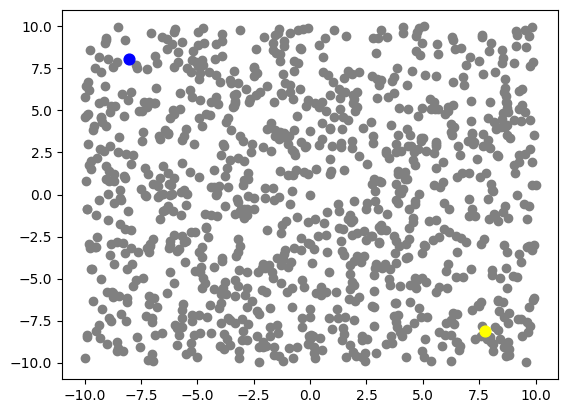

[[ 7.95171911 -7.91812455]
 [-7.84125165  7.85939118]]


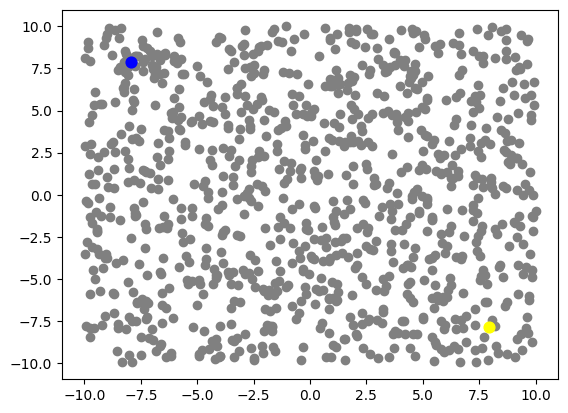

[[ 8.13193179 -7.69792654]
 [-7.67284209  7.86303408]]


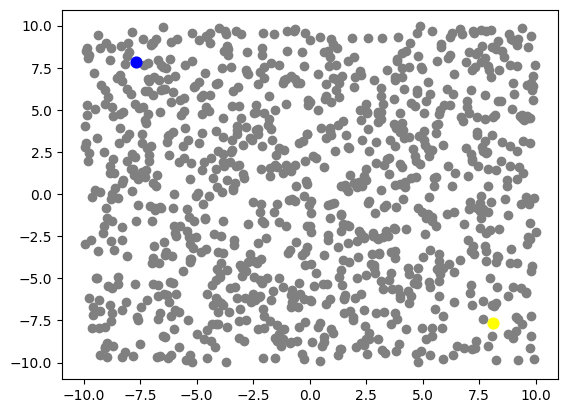

[[ 7.9888288  -7.76085566]
 [-8.1910337   8.36674118]]


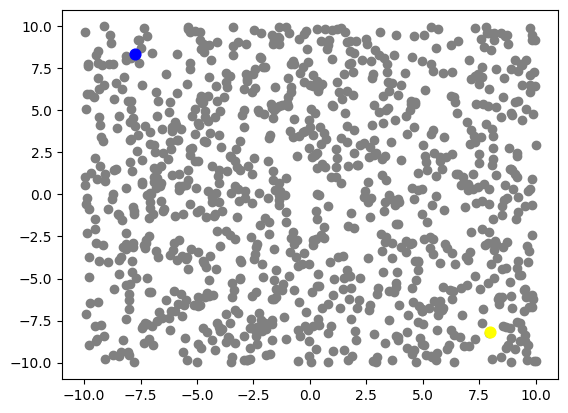

[[-8.02242545  7.75194743]
 [ 7.76175852 -8.18619636]]


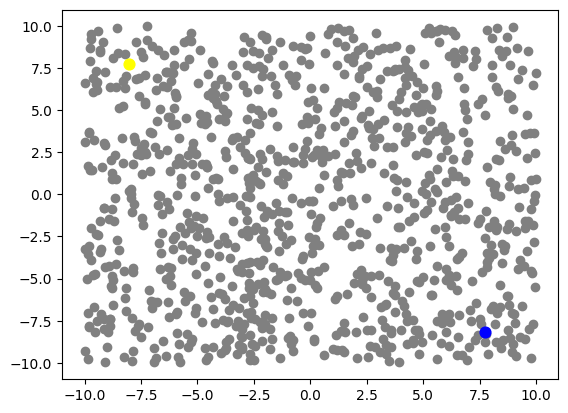

[[-8.05692605  8.46161626]
 [ 8.03002847 -8.00884185]]


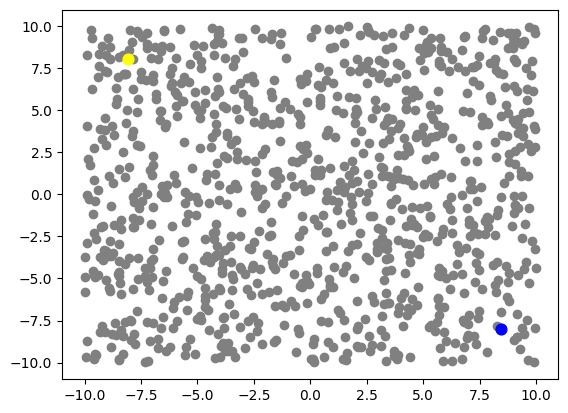

[[-7.7676295   7.84806783]
 [ 7.76225344 -7.95088815]]


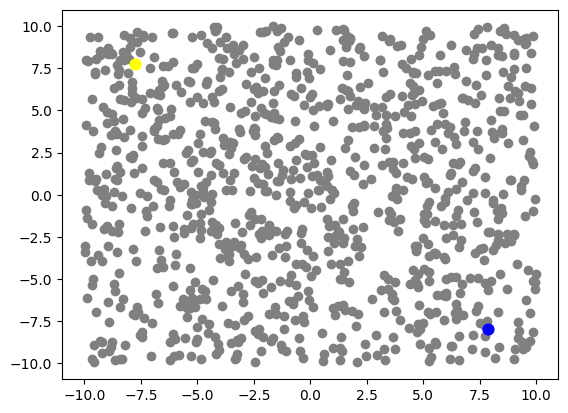

[[-7.87933049  7.95745159]
 [ 7.91655027 -8.19471815]]


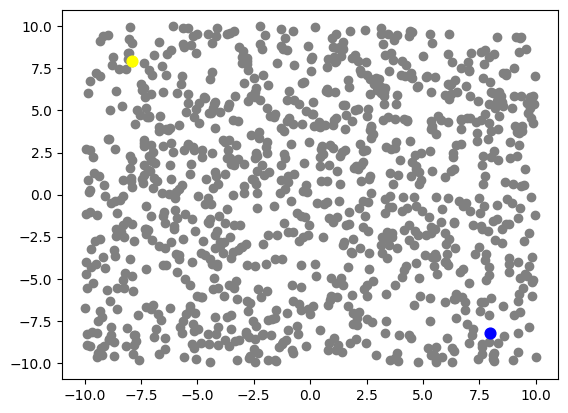

[[-7.98331945  7.71440565]
 [ 8.18574406 -7.82721832]]


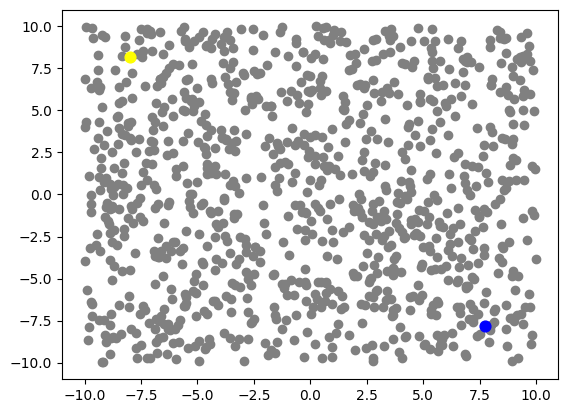

In [ ]:
for i in range(len(rep_val)):
  start = (i*1000)
  end = 1000+start
  x = X[start:end]
  plt.scatter(x[:,0],x[:,1], color='gray')
  print(rep_val[i])
  plt.scatter(rep_val[i][0][0],rep_val[i][1][0], marker='o', color='yellow', s=60)
  plt.scatter(rep_val[i][0][1],rep_val[i][1][1], marker='o', color='blue', s=60)
  plt.show()

In [ ]:
res = []

for s in shaps:
  tmp = s.values
  tmp = np.abs(tmp)
  tmp = tmp.mean(axis=0)
  tmp = tmp.mean(axis=1)
  res.append(tmp)
res = np.array(res)

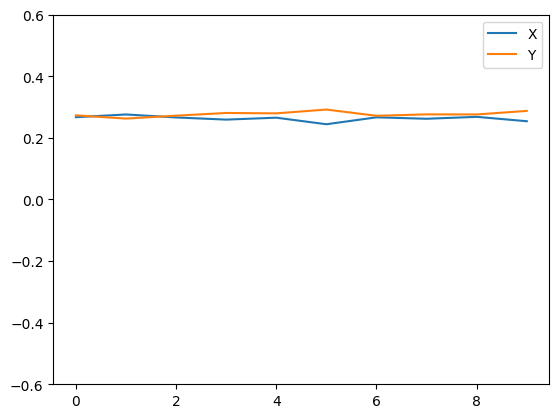

In [ ]:
names = ['X','Y']
for feature in range(len(res[0])):
  plt.plot(res[:,feature], label=names[feature])
plt.legend()
ax = plt.gca()
ax.set_ylim([-0.6,0.6])
plt.show()